<a href="https://colab.research.google.com/github/arpitlabs/azure-openai-client/blob/main/simple_chatbot_gradio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Activating the Azure Credits from your Visual Studio Subscription
1. **Go to the Portal:** Navigate to https://my.visualstudio.com and sign in with the Microsoft Account (MSA) or work/school account tied to your subscription.
2. **Find Azure Benefit:** On the Benefits page, locate the Azure tile within the "Tools" section.
3. **Activate:** Click the Activate button on the Azure tile.
4. **Create Subscription:** If you don't have an Azure subscription, you'll be prompted to create one; this usually sets up a new Azure tenant for your credits.
5. **Verify Identity:** Enter your phone number and verify your identity with a code sent to you.
6. **Accept Terms:** Accept the terms and conditions, then sign up.
7. **Access Azure:** You'll be redirected to the Azure portal's QuickStart Center, where you can create resources using your monthly credits.

## 2. Creating an Azure OpenAI resource and deploy `gpt-4.1-mini`

Follow these step-by-step instructions in the Azure Portal to create a new Azure OpenAI resource and add a model deployment named `gpt-4.1-mini`.

1. Sign in to the Azure Portal: https://portal.azure.com
2. Create the resource:
	- Click **Create a resource** in the left-hand menu.
	- Search for **Azure OpenAI** and select the **Azure OpenAI** offering, then click **Create**.
	- Fill the basics:
	  - **Subscription**: choose your subscription.
	  - **Resource group**: select an existing group or create a new one.
	  - **Region**: choose a region (pick one where Azure OpenAI is available).
	  - **Name**: enter a unique name for the resource (this appears in the endpoint URL).
	- Click **Review + create**, then **Create**. Wait for deployment to finish.
3. Open the created Azure OpenAI resource from the portal (click **Go to resource** after creation or find it in **Resources**).
	- From the resource overview, click the **Go to Foundry Portal** link. This opens the resource in the Microsoft Foundry portal where model deployments are managed.
4. In the Foundry Portal create a model deployment for `gpt-4.1-mini`:
	- In the Foundry left menu click **Deployments**.
	- Click **Create** (or **Deploy model** → **Deploy base model** depending on the UI flow).
	- Select **gpt-4.1-mini** as the base model.
	- Pick a short **Deployment name** (for example: `gpt-4-1-mini-deploy`) — this name is the `deployment id` you'll pass to the CLI.
	- Configure instance/scale settings if required, then click **Create** (or **Deploy**). Wait for provisioning to complete (this can take several minutes).
5. Generate/copy credentials and endpoint (if not already copied):
	- Back in the Azure Portal (resource page) open **Keys and Endpoint** in the left menu.
	- Copy one of the **Keys** (you'll use this as the API key).
	- Copy the **Endpoint** URL (it looks like `https://<your-resource>.openai.azure.com/`).

Notes:
- If `gpt-4.1-mini` is not visible, your subscription may not have quota for that model or it may not be available in the selected region — choose a supported model or request access.
- Keep your key secret. Don't commit it to source control.


## 3. Building your chatbot

First, copy your Azure OpenAI Key from your model deployment to your Notebook's **Secrets** (the Key icon on the left navigation bar). Use `AZURE_OPENAI_KEY` as the key name.

Also enable the Notebook Access.

![PLK243[1].jpg](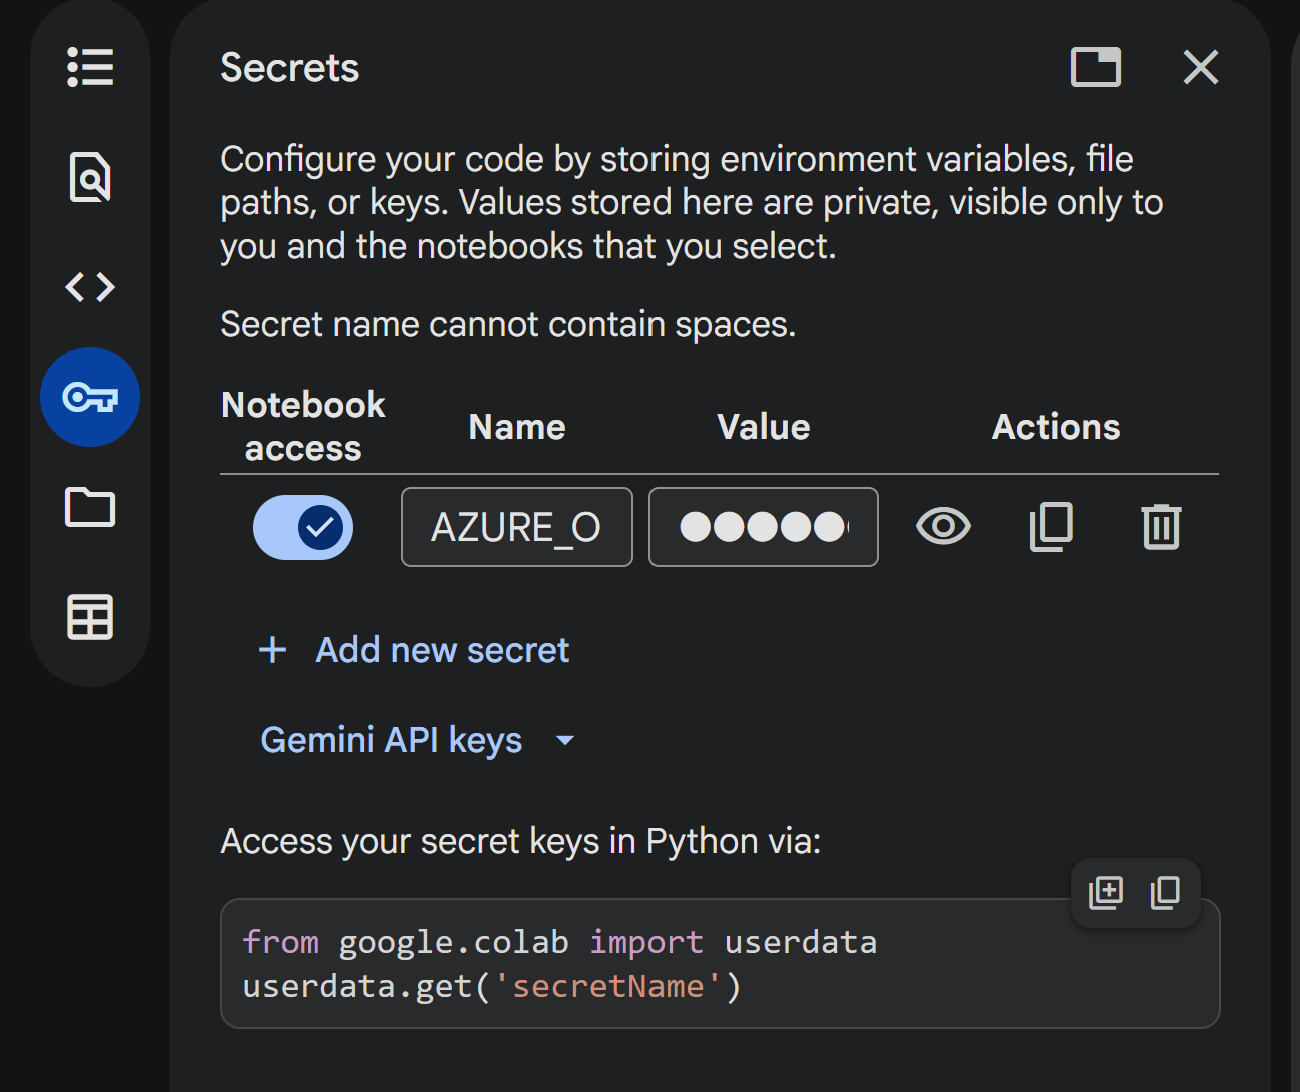)


Next, in the code - import the required libraries, set up the required variables, secrets.



In [ ]:
import os
import gradio as gr
from openai import AzureOpenAI
from google.colab import userdata

MODEL = "gpt-4.1-mini"
AZURE_ENDPOINT = "https://arpitk-openai-003.openai.azure.com/" # <= Your endpoint here.
SYSTEM_PROMPT = "You are a helpful assistant." # <= Your system prompt here.

# AZURE_OPENAI_KEY = os.getenv("AZURE_OPENAI_KEY")
AZURE_OPENAI_KEY = userdata.get('AZURE_OPENAI_KEY')
print(AZURE_OPENAI_KEY)
if not AZURE_OPENAI_KEY:
    raise ValueError("Please set the AZURE_OPENAI_KEY.")

Initialize AzureOpenAI client

In [ ]:
client = AzureOpenAI(
    api_version="2024-12-01-preview",
    azure_endpoint=AZURE_ENDPOINT,
    api_key=AZURE_OPENAI_KEY,
)

Define a function to have a conversation with the LLM using `client`

In [ ]:
def respond(message: str, chat_history):
    """Minimal handler: sends conversation to Azure OpenAI and returns updated history.

    Expects chat_history in Gradio 'messages' format (list of {'role','content'} dicts).
    """
    if not message or not message.strip():
        return chat_history or [], ""

    # Ensure history is a list; default to empty list
    chat_history = chat_history or []

    # Build messages for the API: system prompt + existing history + new user message
    messages = [{"role": "system", "content": SYSTEM_PROMPT}] + chat_history + [
        {"role": "user", "content": message}
    ]

    # Send the messages to the LLM, get the response
    resp = client.chat.completions.create(
        model=MODEL,
        messages=messages,
        temperature=0.2,
        max_tokens=800,
    )

    # Simple extraction with basic fallback
    try:
        assistant_text = resp.choices[0].message.content
    except Exception:
        try:
            assistant_text = resp.choices[0].text
        except Exception:
            assistant_text = str(resp)

    # Append to history in 'messages' format and return (plus clear textbox)
    updated = chat_history + [{"role": "user", "content": message}, {"role": "assistant", "content": assistant_text}]
    return updated, ""

Initiate gradio and launch the chat interface:

In [ ]:
def reset():
    return [], ""

with gr.Blocks() as demo:
    gr.Markdown("## Minimal Azure OpenAI + Gradio Chatbot")
    chatbot = gr.Chatbot(type="messages", allow_tags=True)
    txt = gr.Textbox(show_label=False, placeholder="Type a message and press Enter")
    send = gr.Button("Send")
    clear = gr.Button("Clear")

    txt.submit(respond, [txt, chatbot], [chatbot, txt]) # Enter = submit
    send.click(respond, [txt, chatbot], [chatbot, txt]) # Send = submit
    clear.click(reset, None, [chatbot, txt])

    demo.launch()
